# Imports & Setup

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import classification_report, confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [2]:
# load file

df = pd.read_csv("AFE_nlp.csv")
df

,Report_ID,System,Component,Flight_Phase,Model_Age,Severity,Clean_Narrative,Primary_Fault_Type
0,4059770,Hydraulic,Pump,Cruise,14,Low,pump failed respond irregular cycling observed...,other
1,4021362,A/C (Environmental),Compressor,Climb,21,Moderate,compressor cycling irregularly passenger disco...,other
2,4127324,Electrical,Bus Tie,Climb,25,Low,bus tie fault reported unexpected shutdown led...,other
3,4140509,A/C (Environmental),Ventilation Fan,Taxi,30,Moderate,report checklist execution due ventilation fan...,other
4,4144297,Avionics,Flight Computer,Landing,29,Low,flight computer produced erroneous reading ove...,other
...,...,...,...,...,...,...,...,...
150295,4040287,Electrical,Circuit Breaker,Cruise,21,Low,circuit breaker fault reported irregular cycli...,electrical
150296,4022943,Electrical,Bus Tie,Cruise,7,Moderate,cruise bus tie experienced leak crew observed ...,other
150297,4012699,A/C (Environmental),Temperature Sensor,Descent,29,Low,temperature sensor cycling irregularly avionic...,sensor
150298,4086513,Electrical,Circuit Breaker,Descent,13,Low,descent circuit breaker experienced short circ...,electrical


In [4]:
df.shape

(150300, 8)

In [9]:
df.sample(5)

,Report_ID,System,Component,Flight_Phase,Model_Age,Severity,Clean_Narrative,Primary_Fault_Type
36608,4105462,Electrical,Power Bus,Landing,21,Low,crew noted reduced thrust power bus showed flu...,electrical
102127,4141810,Electrical,Power Bus,Cruise,27,Low,cruise power bus experienced failing crew obse...,electrical
52815,4007206,A/C (Environmental),Compressor,Cruise,21,Low,compressor cycling irregularly manual reset pa...,other
65740,4077995,Electrical,Circuit Breaker,Cruise,7,Low,crew noted reduced thrust circuit breaker show...,electrical
114444,4004430,Hydraulic,Hydraulic Line,Taxi,13,Low,hydraulic line failed respond instability obse...,other


In [15]:
df.isna().sum().sort_values(ascending=False)

Clean_Narrative       1603
Component              750
Severity               447
Report_ID                0
System                   0
Flight_Phase             0
Model_Age                0
Primary_Fault_Type       0
dtype: int64

In [16]:
# Text columns → empty string
df['Clean_Narrative'] = df['Clean_Narrative'].fillna("")

# Categorical columns → 'Unknown'
categorical_features = [
    'System',
    'Component',
    'Flight_Phase',
    'Primary_Fault_Type'
]

for col in categorical_features:
    df[col] = df[col].fillna("Unknown")

# Numerical columns → median
df['Model_Age'] = df['Model_Age'].fillna(df['Model_Age'].median())

In [30]:
df.isna().sum().sort_values(ascending=False)


Report_ID             0
System                0
Component             0
Flight_Phase          0
Model_Age             0
Severity              0
Clean_Narrative       0
Primary_Fault_Type    0
dtype: int64

In [29]:
df['Severity'].isna().sum()

0

In [28]:
# droping rows
df = df.dropna(subset=['Severity']).reset_index(drop=True)

### Target Distribution

In [31]:
df['Severity'].value_counts(normalize=True)

Severity
Low            0.540390
Moderate       0.223532
Significant    0.149747
Major          0.086331
Name: proportion, dtype: float64

In [32]:
# defining features

categorical_features = [
    'System',
    'Component',
    'Flight_Phase',
    'Primary_Fault_Type'
]

numerical_features = [
    'Model_Age'
]

text_feature = 'Clean_Narrative'

X = df[categorical_features + numerical_features + [text_feature]]
y = df['Severity']

In [33]:
# train-test split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

### Preprocessing Pipeline

In [34]:
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        ('num', 'passthrough', numerical_features),
        ('txt', TfidfVectorizer(
            max_features=3000,
            ngram_range=(1,2),
            min_df=5
        ), text_feature)
    ]
)

In [35]:
# Logistic Regression Pipeline

log_reg_pipeline = Pipeline(
    steps=[
        ('preprocess', preprocessor),
        ('model', LogisticRegression(
            max_iter=1000,
            class_weight='balanced',
            n_jobs=-1
        ))
    ]
)

In [36]:
log_reg_pipeline.fit(X_train, y_train)

,steps,"[('preprocess', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat', ...), ('num', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [37]:
y_pred_lr = log_reg_pipeline.predict(X_test)

print(classification_report(y_test, y_pred_lr))

              precision    recall  f1-score   support

         Low       0.55      0.20      0.29     16196
       Major       0.09      0.32      0.14      2587
    Moderate       0.23      0.24      0.24      6700
 Significant       0.16      0.29      0.20      4488

    accuracy                           0.23     29971
   macro avg       0.26      0.26      0.22     29971
weighted avg       0.38      0.23      0.25     29971



In [57]:
import joblib

joblib.dump(log_reg_pipeline, "severity_prediction_model.pkl")

['severity_prediction_model.pkl']

In [58]:
y_proba_reg = log_reg_pipeline.predict_proba(X_test)

In [59]:
y_proba_reg.shape

(29971, 4)

#### ROC-AUC

In [60]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score

In [61]:
classes = log_reg_pipeline.named_steps['model'].classes_
y_test_bin = label_binarize(y_test, classes=classes)

In [62]:
roc_auc = roc_auc_score(
    y_test_bin,
    y_proba_reg,
    average='macro',
    multi_class='ovr'
)

roc_auc

0.514778170623688

# HistGradientBoostingClassifier

#### This over XGBoost?
	•	No external dependency
	•	Airbus interviewers prefer sklearn-native clarity
	•	Fast + strong on tabular data 

In [46]:
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer

In [47]:
tfidf_dense = Pipeline(
    steps=[
        ('tfidf', TfidfVectorizer(
            max_features=1500,
            ngram_range=(1,2),
            min_df=5
        )),
        ('to_dense', FunctionTransformer(
            lambda x: x.toarray(),
            accept_sparse=True
        ))
    ]
)

In [48]:
# processor
gb_preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(
            handle_unknown='ignore',
            sparse_output=False
        ), categorical_features),

        ('num', 'passthrough', numerical_features),

        ('txt', tfidf_dense, text_feature)
    ]
)

In [49]:
gb_pipeline = Pipeline(
    steps=[
        ('preprocess', gb_preprocessor),
        ('model',
            HistGradientBoostingClassifier(
                max_depth=8,
                max_iter=200,
                learning_rate=0.05,
                random_state=42
            )
        )
    ]
)

In [50]:
gb_pipeline.fit(X_train, y_train)

,steps,"[('preprocess', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat', ...), ('num', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [51]:
y_pred_gb = gb_pipeline.predict(X_test)

In [54]:
print(classification_report(y_test, y_pred_gb))

              precision    recall  f1-score   support

         Low       0.54      1.00      0.70     16196
       Major       0.00      0.00      0.00      2587
    Moderate       0.00      0.00      0.00      6700
 Significant       0.00      0.00      0.00      4488

    accuracy                           0.54     29971
   macro avg       0.14      0.25      0.18     29971
weighted avg       0.29      0.54      0.38     29971



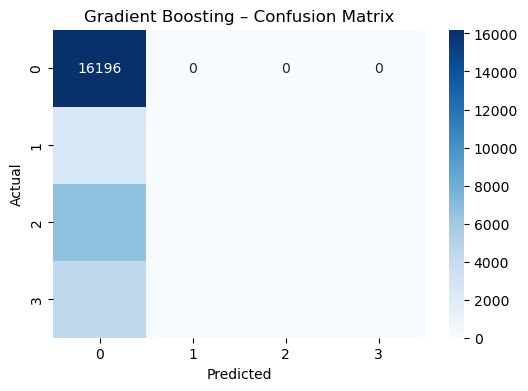

In [55]:
cm = confusion_matrix(y_test, y_pred_gb)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Gradient Boosting – Confusion Matrix")
plt.show()